## **Reto**: Comparación Molecular

El objetivo de este reto es seleccionar de entre una base de datos de moléculas (`candidate_molecules`) aquellas que más se asemejen a una molécula de referencia (`target_molecule`). Este procedimiento es parte del proceso de descubrimiento de nuevos medicamentos, en el que se filtra un gran número inicial de candidatos *in silico* antes de llevar las pruebas al laboratorio. 

La metodología para comparar 2 moléculas, `mol1` y `mol2` es la siguiente:

### 1º Grafos moleculares

Modelamos las moléculas como grafos, en donde los nodos representan átomos y las aristas enlaces. Además, asignamos a los nodos y aristas etiquetas que guarden información química relevante que emplearemos en los siguientes pasos.

### 2º Determinamos la máxima subestructura coincidente entre los dos grafos

Estimamos una métrica del grado de similitud entre `mol1` y `mol2` calculando cuál es la mayor subestructura común a ambos grafos. Este es un problema NP-hard y es el que resolveremos con computación cuántica y de inspiración cuántica a través de su formulación QUBO. 

Dados los grafos moleculares correspondientes a las 2 moléculas, `mol_graph1` y `mol_graph2`, contruiremos un tercer grafo llamado grafo de conflicto en el que sus:
- nodos son pares de nodos de `mol_graph1` y `mol_graph2`, representando posibles identificaciones
- aristas representan confictos entre las posibles asignaciones.

**Por ejemplo**, si tenemos los nodos en el grafo de conflicto $(n_1^{mol1},n_1^{mol2})$ y $(n_1^{mol1},n_2^{mol2})$, habrá una arista entre ellos porque estas dos asignaciones están en conflicto: un nodo de una molécula ($n_2^{mol1}$) no puede identificarse con más de un nodo de la otra molécula ($n_1^{mol2}$ y $n_2^{mol2}$).

Así, la máxima subestructura coincidente entre los dos grafos vendrá dada por el mayor subconjunto de nodos tal que no haya ninguna arista entre ellos. En teoría de grafos, tal conjunto se llama **Maximum Independent Set (MIS)**, y admite una formulación QUBO:
$$
QUBO_{MIS} = -\sum_{n\in V} x_n + \sum_{(n,m)\in E}\lambda_{n,m} x_{n}x_{m}
$$
para un grafo $G$ con vértices $V$ y aristas $E$, con $\lambda_{n,m} > 1$.

En nuestro grafo de conflicto tendremos además pesos, dado que el nivel de similitud entre dos pares de átomos distintos entre moléculas no tiene por qué ser igual y dependenderá de propiedades químicas (como la carga parcial, el número de enlaces en lo que participa, el tipo de átomo, etc.). Así, el problema que queremos resolver no es MIS, sino el **Maximum Weighted Independent Set (MWIS)**. Si cada nodo $n$ tiene asociado un peso $w_n$, entonces podemos adaptar la fórmula anterior fácilmente:
$$
QUBO_{MWIS} = -\sum_{n\in V} w_n x_n + \sum_{(n,m)\in E}\lambda_{n,m} x_{n}x_{m}
$$
y $\lambda_{n,m} > min\{w_n,w_m\}$.

En el repositorio asociado a este reto, os proporcionamos una clase para importar las moléculas target y candidatas. Como el las dimensiones de los problemas que podemos resolver con QAOA y con DA son radicalmente diferentes, os pedimos que realicéis la comparación con conjuntos de moléculas distintos con cada una de las tecnologías. A continuación os indicamos cómo las podéis cargar: 

In [ ]:
from modules.load_molecules import MolLoader

mol_loader = MolLoader()

# Load DA molecules
target_mol_DA, candidate_mols_DA = mol_loader.load_molecules_DA()

Estamos usando una librería open-source ampliamente extendida en el campo de la química computacional: `rdkit`. Nos permite visualizar las moléculas como estructuras 2D.

In [2]:
target_mol_DA

{'ZINC03832339': <rdkit.Chem.rdchem.Mol at 0x1621da53d10>}

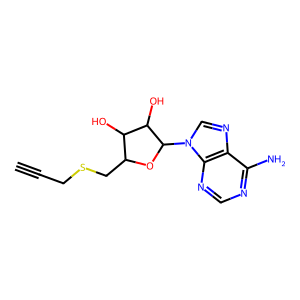

In [15]:
from rdkit.Chem import Draw
Draw.MolToImage(list(target_mol_DA.values())[0])

A partir de este objeto de `rdkit` construimos el grafo molecular:

In [ ]:
from modules.molecular_graph import MolecularGraphDA

# Create molecular graphs DA
target_mol_name_DA = list(target_mol_DA.keys())[0]
target_mol_graph_DA = MolecularGraphDA(molecule=target_mol_DA[target_mol_name_DA],
                                       mol_name=target_mol_name_DA)

candidate_mol_graphs_DA = {
    mol_name: MolecularGraphDA(molecule=mol,mol_name=mol_name) 
    for mol_name, mol in candidate_mols_DA.items()
    }



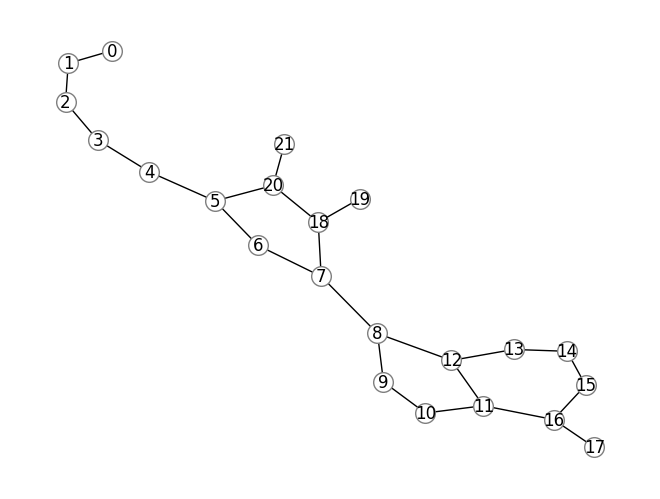

In [32]:
import networkx as nx
options = {"edgecolors": "tab:gray", "node_size": 200, "alpha": 1}
nx.draw(target_mol_graph_DA.mol_graph, pos = nx.spring_layout(target_mol_graph_DA.mol_graph),node_color='white' ,with_labels=True, **options)

Finalmente, para cada par de moléculas, podemos generar el correspondiente grafo de conflicto:

In [ ]:
# Create conflict graphs for DA
from modules.conflict_graph import ConflictGraph

conflict_graphs_DA = {
    mol_name: ConflictGraph(mol_graph_target=target_mol_graph_DA, 
                            mol_graph_candidate=candidate_mol_graphs_DA[mol_name])
    for mol_name in candidate_mol_graphs_DA.keys()
    }

## Resolución con Digital Annealer

A partir de estos objetos de la [librería de python para la manipulación de grafos](https://networkx.org/documentation/stable/) `networkx`, implementad la QUBO para el cálculo del MWIS y minizadla con el solver local de la librería `dadk`.

**AYUDA**: A continuación mostramos cómo acceder a los nodos y aristas de un grafo en `networkx`

In [ ]:
# Access nodes of a networkx graph
example_graph = list(conflict_graphs_DA.values())[0].graph
print(example_graph.nodes(data=True)) # Key is the node index, value is the node data (weight)
# for node,node_data in example_graph.nodes(data=True):
#     print(node,node_data)
print('\n')

# Access edges of a networkx graph
print(example_graph.edges(data=True)) # Tuple with 3 elements: el0 is the node1, el1 is node2, el3 is the edge data (weight,confict type)
# for node1,node2,edge_data in example_graph.edges(data=True):
    # print(node1,node2,edge_data)

[((0, 1), {'weight': np.float64(0.6111111111111112)}), ((0, 2), {'weight': np.float64(0.6666666666666666)}), ((0, 4), {'weight': np.float64(0.6666666666666666)}), ((0, 7), {'weight': np.float64(0.6666666666666666)}), ((0, 8), {'weight': np.float64(0.6111111111111112)}), ((0, 9), {'weight': np.float64(0.6111111111111112)}), ((0, 11), {'weight': np.float64(0.6666666666666666)}), ((0, 13), {'weight': np.float64(0.6111111111111112)}), ((0, 15), {'weight': np.float64(0.6666666666666666)}), ((0, 17), {'weight': np.float64(0.8333333333333334)}), ((1, 1), {'weight': np.float64(0.6666666666666666)}), ((1, 2), {'weight': np.float64(0.6111111111111112)}), ((1, 4), {'weight': np.float64(0.6111111111111112)}), ((1, 7), {'weight': np.float64(0.6666666666666666)}), ((1, 8), {'weight': np.float64(0.6666666666666666)}), ((1, 9), {'weight': np.float64(0.6666666666666666)}), ((1, 11), {'weight': np.float64(0.6666666666666666)}), ((1, 13), {'weight': np.float64(0.6666666666666666)}), ((1, 15), {'weight': 

**AYUDA**: Recomendamos implementarlo como una clase o una función que tome como input un grafo de conflicto y genere un objeto de clase `BinPol` de la librería `dadk`.

In [ ]:
#### YOUR CODE HERE #### (implement the QUBO formulation)







#### END YOUR CODE ####